In [2]:
!pip install --upgrade lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 8.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 7.1 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=9474b835c30c57a248b2fd1924290658d738eca685475084e59332c4c0ed9a0f
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import polars as pl

import pandas.api.types
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import lightgbm as lgb
import xgboost as xgb
import catboost as cb

import lifelines
from lifelines.utils import concordance_index

import sys

print(sys.version)
for i in [np, pd, pl, mpl, sns, lifelines, sklearn, lgb, xgb, cb]:
    try:
        print(i.__name__, i.__version__)
    except:
        print(i.__name__)

3.12.6 (main, Sep 30 2024, 02:19:13) [GCC 9.4.0]
numpy 1.26.4
pandas 2.2.3
polars 1.12.0
matplotlib 3.8.4
seaborn 0.13.2
lifelines 0.30.0
sklearn 1.5.2
lightgbm
xgboost 2.1.2
catboost 1.2.5


In [2]:
import dproc, sgutil, sgpp, sgml, custpp
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, KFold, ShuffleSplit, train_test_split
from sklearn.impute import SimpleImputer
from lifelines import NelsonAalenFitter

In [3]:
data_path = 'data'
img_path = 'img'
result_path = 'result'
model_path = 'model'

sc = sgutil.SGCache(img_path, result_path)

X_4 = [
    'psych_disturb', 'diabetes', 'arrhythmia', 'renal_issue', 'pulm_severe', 'obesity', 'hepatic_severe', 
    'prior_tumor', 'peptic_ulcer','rheum_issue', 'hepatic_mild', 'cardiac','pulm_moderate'
]

X_int_fm = [
    'comorbidity_score', 'hla_high_res_10', 'hla_high_res_6', 'hla_high_res_8', 'hla_low_res_10',
    'hla_low_res_6', 'hla_low_res_8', 'hla_match_a_high', 'hla_match_a_low', 'hla_match_b_high',
    'hla_match_b_low', 'hla_match_drb1_low', 'hla_match_c_high', 'hla_match_c_low', 'hla_match_dqb1_high', 'hla_match_dqb1_low',
    'hla_match_drb1_high', 'hla_nmdp_6', 'karnofsky_score'
]

X_2 = [
    ('graft_type', {'peripheral blood': 0, 'bone marrow': 1}),
    ('prod_type', {'pb': 0, 'bm': 1}),
    ('vent_hist', {'no': -1, 'yes': 1}),
    ('rituximab', {'no': -1, 'yes': 1}),
    ('mrd_hct', {'negative': -1, 'positive': 1}),
    ('in_vivo_tcd', {'no': -1, 'yes': 1}),
    ('melphalan_dose', {'n/a, mel not given': -1, 'mel': 1})
]
X_na = X_4 +  X_int_fm +  ['donor_age']
X_nom_na = ['cmv_status', 'conditioning_intensity', 'cyto_score', 'cyto_score_detail', 'donor_related',
    'dri_score', 'ethnicity', 'gvhd_proph', 'sex_match', 'tce_div_match', 'tce_imm_match', 'tce_match'
]
X_nom_nna = ['prim_disease_hct', 'race_group', 'tbi_status']
p2 = make_pipeline(
    sgpp.PolarsProcessor({'ID': pl.Int64}),
    sgpp.PandasCoverter(index_col = 'ID'),
    custpp.CIBMTTransformer(X_2, X_4, X_na, X_nom_na + X_nom_nna),
    sgpp.ApplyWrapper(SimpleImputer(strategy='most_frequent').set_output(transform='pandas'), X_int_fm, postfix = '_fm'),
    sgpp.ApplyWrapper(SimpleImputer(strategy='mean').set_output(transform='pandas'), ['donor_age'], postfix = '_fm'),
    sgpp.ApplyWrapper(sgpp.CatArrangerFreq(1, 'na', 'na'), X_nom_na),
    sgpp.ApplyWrapper(sgpp.CatOOVFilter(), X_nom_nna),
)
df_train = p2.fit_transform(['data/train.csv'])
joblib.dump(p2, os.path.join('model', 'p2.joblib'))

['model/p2.joblib']

In [4]:
def get_naf(df, time_col='efs_time', event_col='efs'):
    naf = NelsonAalenFitter()
    naf.fit(durations=df['efs_time'], event_observed=df['efs'])
    return naf.cumulative_hazard_at_times(df['efs_time']).values * -1
df_train['naf'] = get_naf(df_train, time_col='efs_time', event_col='efs')

In [5]:
X_bool = ['graft_type', 'prod_type']
X_tri = [
    'arrhythmia', 'cardiac', 'diabetes', 'hepatic_mild', 'hepatic_severe',
    'in_vivo_tcd', 'melphalan_dose', 'mrd_hct', 'obesity', 'peptic_ulcer',
    'prior_tumor', 'psych_disturb', 'pulm_moderate', 'pulm_severe', 'renal_issue',
    'rheum_issue', 'rituximab', 'vent_hist'
]
X_nom = [
    'cmv_status', 'conditioning_intensity', 'cyto_score', 'cyto_score_detail', 'donor_related',
    'dri_score', 'ethnicity', 'gvhd_proph', 'prim_disease_hct', 'race_group', 'sex_match',
    'tbi_status', 'tce_div_match', 'tce_imm_match', 'tce_match'
]
X_na = [
    'arrhythmia_na', 'cardiac_na', 'diabetes_na', 'hepatic_mild_na', 'hepatic_severe_na',
    'obesity_na', 'peptic_ulcer_na', 'prior_tumor_na', 'psych_disturb_na', 'pulm_moderate_na',
    'pulm_severe_na', 'renal_issue_na', 'rheum_issue_na'
]
X_cont = ['age_at_hct', 'donor_age']
X_int = [
    'comorbidity_score', 'hla_high_res_10', 'hla_high_res_6', 'hla_high_res_8', 'hla_low_res_10',
    'hla_low_res_6', 'hla_low_res_8', 'hla_match_a_high', 'hla_match_a_low', 'hla_match_b_high',
    'hla_match_b_low', 'hla_match_drb1_low', 'hla_match_c_high', 'hla_match_c_low', 'hla_match_dqb1_high', 'hla_match_dqb1_low',
    'hla_match_drb1_high', 'hla_nmdp_6', 'karnofsky_score', 'year_hct'
]


In [7]:
def score(df, prds):
    return df.groupby('race_group', observed=True).apply(
        lambda x: concordance_index(x['efs_time'], -prds.loc[x.index], x['efs']), include_groups=False
    ).pipe(
        lambda x: float(x.mean() - x.std(ddof=0))
    )
def get_validation_splitter(validation_fraction):
    return lambda x: train_test_split(x, test_size = validation_fraction)

config = {
    'predict_func': lambda m, df, X: pd.Series(m.predict(df[X]), index = df.index),
    'score_func': score,
    'validation_splitter': get_validation_splitter,
    'progress_callback': sgml.ProgressCallBack(), 
    'return_train_scores': True,
    'y': 'naf',
}

kf = KFold(n_splits=10, shuffle=True, random_state = 123)
ss = ShuffleSplit(n_splits=1, random_state = 123)
lgb_adapter = sgml.LGBMAdapter(lgb.LGBMRegressor)
xgb_adapter = sgml.XGBAdapter(xgb.XGBRegressor)
cb_adapter = sgml.CBAdapter(cb.CatBoostRegressor)

## Feature Importance & Iteraction

In [22]:
hparams = {
    'model_params': {
        'max_depth': 6, 'n_estimators': 3500, 'learning_rate': 0.03
    },
    'X_num':  X_tri + X_cont + X_int + X_na + X_bool, 'X_cat': X_nom
}
result = sgml.train(df_train, hparams, config, cb_adapter, task_type = 'GPU')

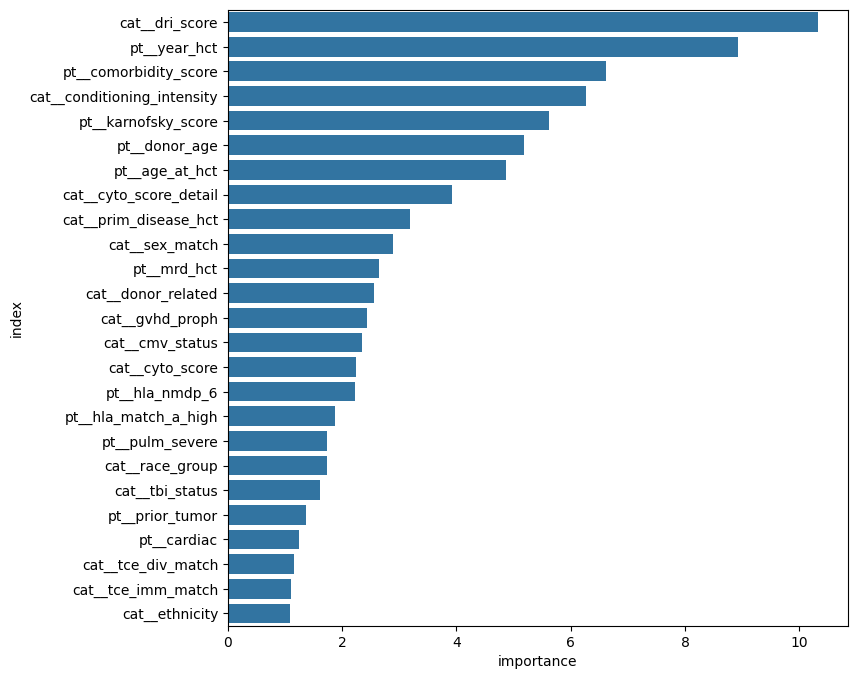

In [23]:
plt.figure(figsize=(8, 8))
sns.barplot(
    sgml.cb_learning_result(result[0])['feature_importance'].sort_values(ascending = False).rename('importance').to_frame().reset_index().iloc[:25], 
    y = 'index', x = 'importance'
)
plt.show()

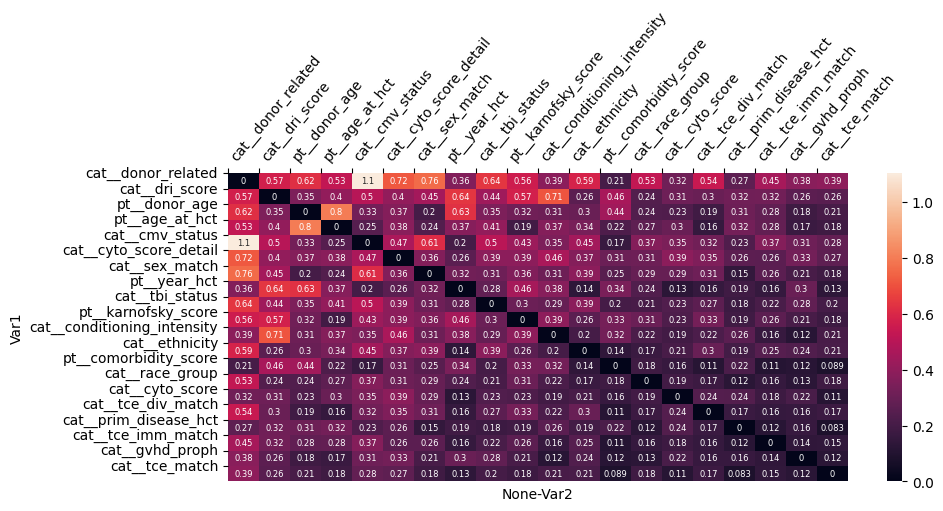

In [24]:
inter = sgml.cb_interaction_importance(result[0])
df_cb_inter = pd.concat([
    inter,
    inter.rename(columns={'Var1': 'Var2', 'Var2': 'Var1'})
], axis=0).pivot(index='Var1', columns='Var2').fillna(0)
s_sum = df_cb_inter.sum()
df_cb_inter = df_cb_inter.iloc[np.argsort(-s_sum)[:20], np.argsort(-s_sum)[:20]]
plt.figure(figsize=(10, 4))
sns.heatmap(df_cb_inter, annot=True, annot_kws = {'size': 6})
plt.yticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=0,
    horizontalalignment="right",
)
plt.xticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
plt.show()

In [27]:
df_train['cmv_status'].value_counts()

cmv_status
+/+    13596
-/+     7081
+/-     4048
-/-     3441
na       634
Name: count, dtype: int64

In [28]:
df_train['donor_related'].value_counts()

donor_related
related                     16208
unrelated                   12088
multiple donor (non-ucb)      346
na                            158
Name: count, dtype: int64

In [38]:
pd.crosstab(
    index = dproc.combine_cat(df_train[['donor_related', 'cmv_status']]),
    columns = df_train['efs'], normalize = 'index'
).join(
    pd.crosstab(
        index = dproc.combine_cat(df_train[['donor_related', 'cmv_status']]),
        columns = df_train['efs']
    ).rename(columns = lambda x: 'cnt_{}'.format(x))
)

efs,0.0,1.0,cnt_0.0,cnt_1.0
row_0,,,,
nana,0.583333,0.416667,7,5
relatedna,0.559113,0.440887,227,179
unrelatedna,0.509804,0.490196,104,100
multiple donor (non-ucb)na,0.583333,0.416667,7,5
na+/+,0.550000,0.450000,33,27
related+/+,0.474574,0.525426,4041,4474
unrelated+/+,0.446399,0.553601,2182,2706
multiple donor (non-ucb)+/+,0.578947,0.421053,77,56
na-/+,0.395349,0.604651,17,26


In [42]:
df_train['dri_score'].value_counts()

dri_score
intermediate                                         10436
n/a - pediatric                                       4779
high                                                  4701
n/a - non-malignant indication                        2427
tbd cytogenetics                                      2003
low                                                   1926
high - ted aml case <missing cytogenetics             1414
intermediate - ted aml case <missing cytogenetics      481
n/a - disease not classifiable                         272
very high                                              198
na                                                     154
missing disease status                                   9
Name: count, dtype: int64

In [46]:
df_train[X_nom].apply(lambda x: x.value_counts().iloc[-1])

cmv_status                 634
conditioning_intensity      62
cyto_score                  55
cyto_score_detail          145
donor_related              158
dri_score                    9
ethnicity                  384
gvhd_proph                   1
prim_disease_hct            20
race_group                4707
sex_match                  261
tbi_status                  76
tce_div_match              593
tce_imm_match               25
tce_match                  868
dtype: int64

In [48]:
df_train[X_nom].apply(lambda x: x.value_counts().index[-1])

cmv_status                                                       na
conditioning_intensity                n/a, f(pre-ted) not submitted
cyto_score                                               not tested
cyto_score_detail                                        not tested
donor_related                                                    na
dri_score                                    missing disease status
ethnicity                                  non-resident of the u.s.
gvhd_proph                                 fk+- others(not mmf,mtx)
prim_disease_hct                                                cml
race_group                native hawaiian or other pacific islander
sex_match                                                        na
tbi_status                               tbi +- other, unknown dose
tce_div_match                         bi-directional non-permissive
tce_imm_match                                                   p/g
tce_match                                       

In [49]:
df_train['gvhd_proph'].value_counts()

gvhd_proph
fk+ mmf +- others                  10440
cyclophosphamide alone              5270
fk+ mtx +- others(not mmf)          4262
cyclophosphamide +- others          2369
csa + mmf +- others(not fk)         2278
fkalone                             1230
other gvhd prophylaxis               550
tdepletion alone                     545
tdepletion +- other                  539
no gvhd prophylaxis                  262
cdselect alone                       251
na                                   225
csa + mtx +- others(not mmf,fk)      224
csa alone                            214
parent q = yes, but no agent          62
cdselect +- other                     55
csa +- others(not fk,mmf,mtx)         23
fk+- others(not mmf,mtx)               1
Name: count, dtype: int64